# Parkinson Data

## Motivation for using EMD - IMfs and Penalised Splines

In [2]:
import numpy as np
import audiofile as af
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
from PyEMD import EMD
import time
import seaborn as sn
from sklearn.gaussian_process.kernels import  (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              WhiteKernel, ConstantKernel) 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics.pairwise import pairwise_kernels
from matplotlib import cm as CM
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import ParameterGrid
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import math
from sklearn.preprocessing import StandardScaler

In [3]:
def calculate_CKTA(Kx,Ky):
    import numpy as np
    Kxc = (Kx.T - np.mean(Kx, axis=0)).T
    Kxc = Kxc - np.mean(Kxc, axis = 1)
    
    Kyc = (Ky.T - np.mean(Ky, axis=0)).T
    Kyc = Kyc - np.mean(Kyc, axis = 1)
    
    numer = np.sum(Kx*Kyc) 
    denomx = np.sum(Kx*Kxc)
    denomy = np.sum(Ky*Kyc)
    
    return  numer/(np.sqrt(denomx*denomy))  



In [4]:
family = 4

grid = []

if family == 0:
    grid = {'l':  np.arange(0.1, 20, 1.5) } 
elif family == 1:
     grid = {'l': [0.1, 2], 'alpha':[0.2, 3]}
elif family == 2:
     grid = {'l': [0.1, 2], 'p':[0.5,1]}
elif family == 3:
     grid = {'l': [0.1, 2], 'nu':[0.5,1]}
elif family == 4:
     grid = {'l1': [0.1, 2], 'l2':[0.1, 2], 'p':[0.5,1]}
elif family == 5:
     grid = {'l': [2, 10], 'mu':[0.5,1]}
                      

 


final_grid = list(ParameterGrid(grid)) 

n_hyper = len(final_grid)



In [149]:
n_hyper

8

In [5]:
K = []
N = 5000
t = np.linspace(0, 1, N) 


kernels = []

if family == 0:
    for i in range(0,n_hyper):
         kernels.append(RBF(length_scale = final_grid[i].get('l'), 
                            length_scale_bounds = [(0.,  10.0)] ))
elif family == 1:
    for i in range(0,n_hyper):
         kernels.append(RationalQuadratic(length_scale = final_grid[i].get('l'), 
                                          alpha = final_grid[i].get('alpha'),
                                          length_scale_bounds = [(0.,  10.0)] ,
                                          alpha_bounds = [(0.1,  10.0)] ))
elif family == 2:
    for i in range(0,n_hyper):
         kernels.append(ExpSineSquared(length_scale = final_grid[i].get('l'), 
                                       periodicity = final_grid[i].get('p'),
                                       length_scale_bounds = [(0.,  10.0)] ,
                                       periodicity_bounds= [(0.1, 10.0)] ))
elif family == 3:
    for i in range(0,n_hyper):
         kernels.append(Matern(length_scale = final_grid[i].get('l'), 
                                       nu = final_grid[i].get('nu'),
                                       length_scale_bounds = [(0.,  10.0)]  ))
elif family == 4:
    for i in range(0,n_hyper):
         kernels.append( ( RBF(length_scale = final_grid[i].get('l1'), 
                               length_scale_bounds = [(0.,  10.0)] ) * 
                           ExpSineSquared(length_scale = final_grid[i].get('l2'), 
                                          periodicity = final_grid[i].get('p'),
                                          length_scale_bounds = [(0.,  10.0)] ,
                                          periodicity_bounds= [(0.1, 10.0)] ) ))
elif family == 5:
    for i in range(0,n_hyper):
            l = final_grid[i].get('l')
            mu = final_grid[i].get('mu')
            K.append(pairwise_kernels(X = t[:,np.newaxis], metric = gaus_spec_kernel))
    


        
###################################
#   Evaluation of Gram Matrices   #
###################################        
        
if not K:
    N = 5000
    t = np.linspace(0, 1, N)
    K = [pairwise_kernels(X = t[:,np.newaxis], metric = kk) for kk in kernels]



In [6]:
len(K)

8

In [7]:
X_train_hc_m = np.load ( 'C:\\Users\\Marta\\Desktop\\Parkinson_data\\Python_code\\Data_extraction_&_preliminaries\\Results\\X_train_hc_m.npy')
X_train_pd_m = np.load ('C:\\Users\\Marta\\Desktop\\Parkinson_data\\Python_code\\Data_extraction_&_preliminaries\\Results\\X_train_pd_m.npy')


In [8]:
my_sig_hc = [X_train_hc_m[0], X_train_hc_m[1000],X_train_hc_m[1700]]
my_sig_pd =  [X_train_pd_m[0], X_train_pd_m[2000],X_train_pd_m[4000]]

my_sig_hc_cent = [ (np.array(np.vstack(my_sig_hc[i])) - np.mean(my_sig_hc[i]))/np.std(my_sig_hc[i])  
                  for i in range(0,len(my_sig_hc))]


my_sig_pd_cent = [ (np.array(np.vstack(my_sig_pd[i])) - np.mean(my_sig_pd[i]))/np.std(my_sig_pd[i])  
                  for i in range(0,len(my_sig_pd))]




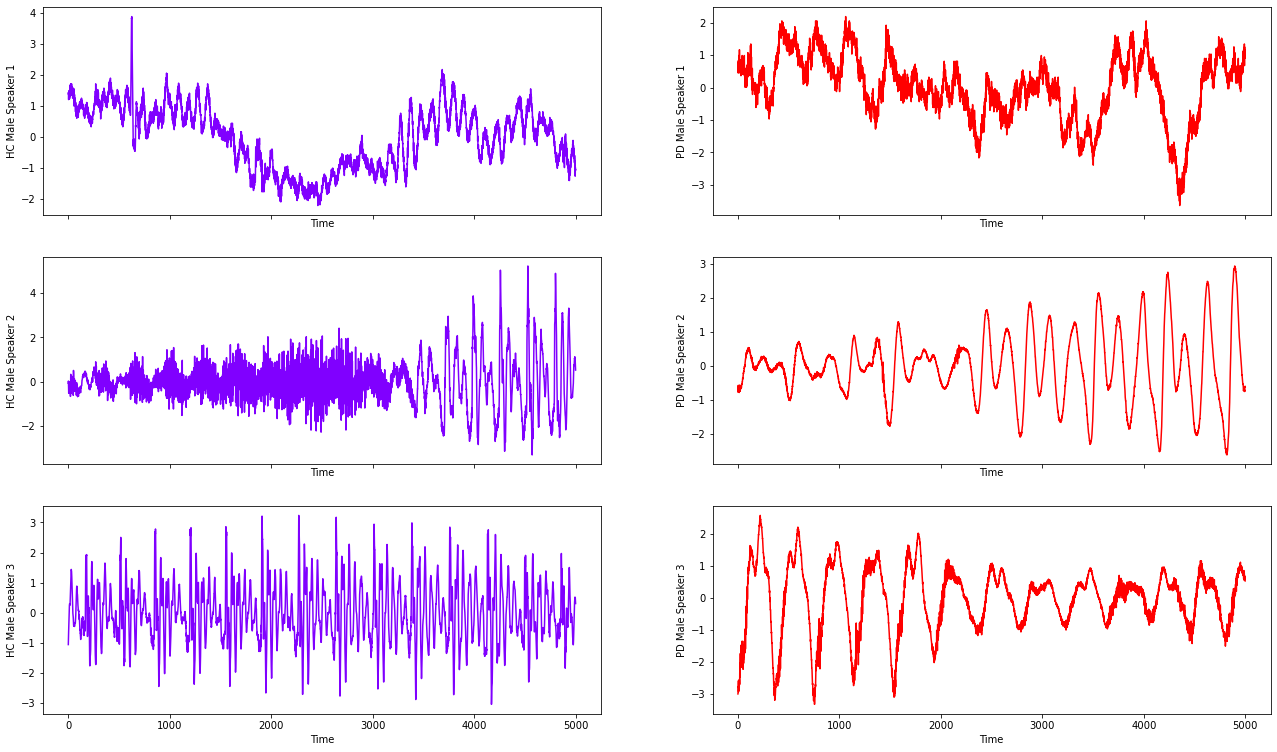

In [13]:
rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(22,13))

for i in range(0,len(my_sig_hc_cent)):
    axes[i,0].plot(my_sig_hc_cent[i], color = rain_col[0])
    axes[i,1].plot(my_sig_pd_cent[i], color = rain_col[1])
    axes[i,0].set_ylabel(format("HC Male Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Time')
    axes[i,1].set_ylabel(format("PD Male Speaker " + str(i+1)))
    axes[i,1].set(xlabel = 'Time')  


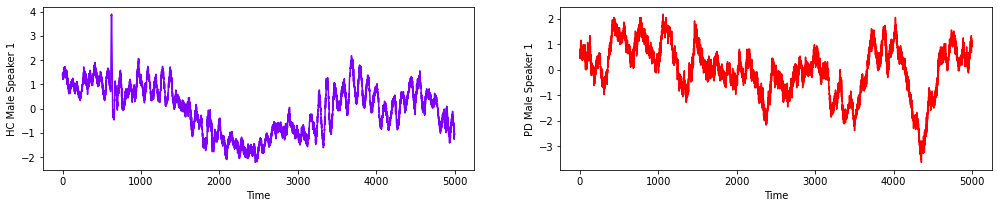

In [23]:
#FOR THE PAPER

rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize=(17,3))

for i in range(0,1):
    axes[0].plot(my_sig_hc_cent[i], color = rain_col[0])
    axes[1].plot(my_sig_pd_cent[i], color = rain_col[1])
    axes[0].set_ylabel(format("HC Male Speaker " + str(i+1)))
    axes[0].set(xlabel = 'Time')
    axes[1].set_ylabel(format("PD Male Speaker " + str(i+1)))
    axes[1].set(xlabel = 'Time')  

fig.savefig("or_sigs.pdf", bbox_inches='tight')

In [10]:
C_hc = [np.dot(my_sig_hc_cent[i], my_sig_hc_cent[i].T) for i in range(0, len(my_sig_hc))]
C_pd = [np.dot(my_sig_pd_cent[i], my_sig_pd_cent[i].T)  for i in range(0, len(my_sig_pd))]


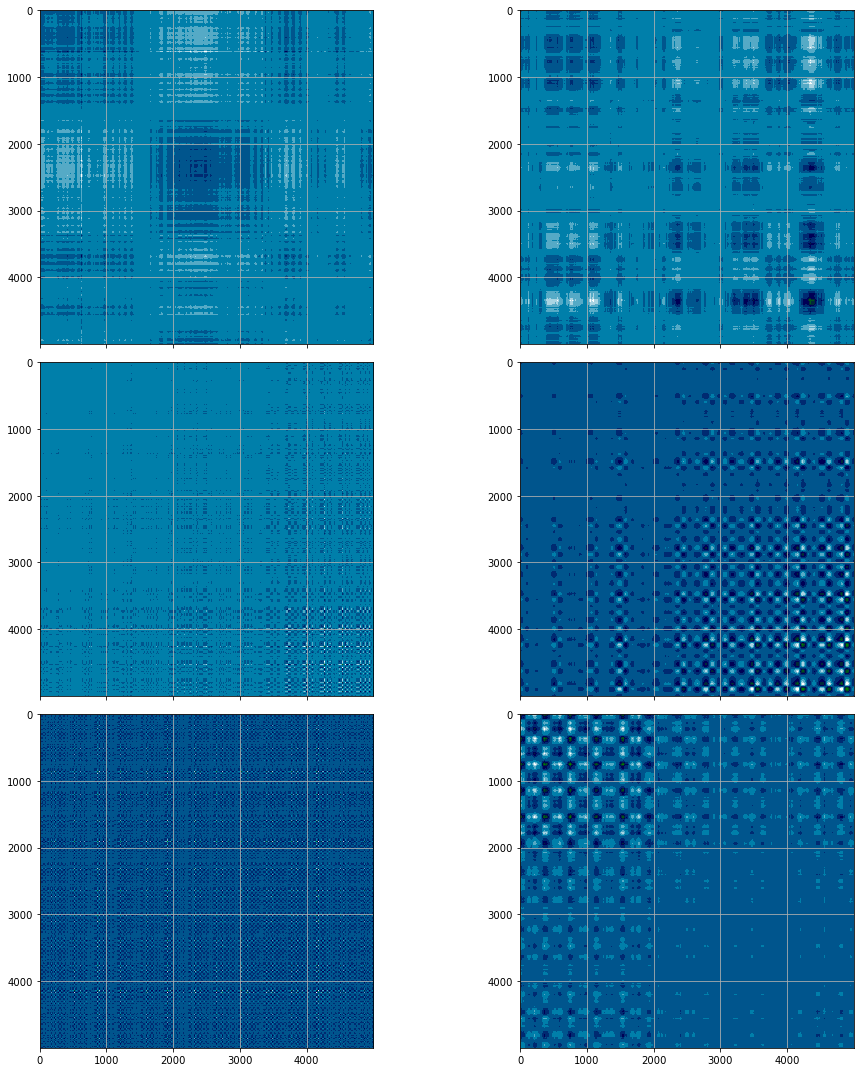

In [14]:
fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_hc[i], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_pd[i], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()



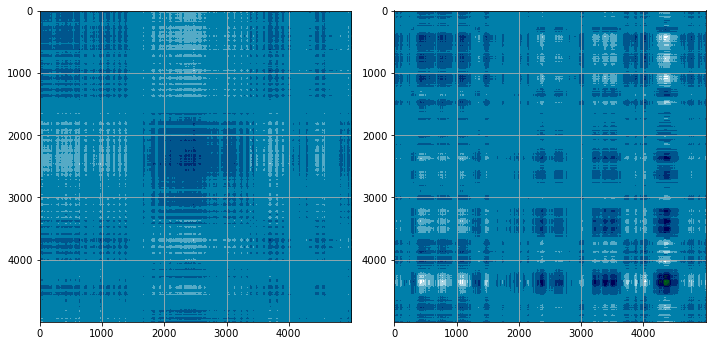

In [27]:
#FOR THE PAPER


fig, axis = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize=(10,10))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,1):
    axis[0].imshow(C_hc[i], interpolation="nearest", cmap=cmap)
    axis[0].grid(True)
    axis[1].imshow(C_pd[i], interpolation="nearest", cmap=cmap)
    axis[1].grid(True)
fig.tight_layout()




fig.savefig("cov_or_sigs.pdf", bbox_inches='tight')

In [13]:
######################################################
## Smoothing Spline -  discuss set_smoothing_factor ##
######################################################

In [25]:
spl_hc = [UnivariateSpline(t, my_sig_hc[i]) for i in range(0,len(my_sig_hc))]
spl_pd = [UnivariateSpline(t, my_sig_pd[i]) for i in range(0,len(my_sig_pd))]

for i in range(0,len(my_sig_hc)):
    spl_hc[i].set_smoothing_factor(0.001)
    spl_pd[i].set_smoothing_factor(0.001)


In [26]:
spl_eval_hc = [spl_hc[i](t) for i in range(0,len(my_sig_hc))]
spl_eval_pd = [spl_pd[i](t) for i in range(0,len(my_sig_pd))]



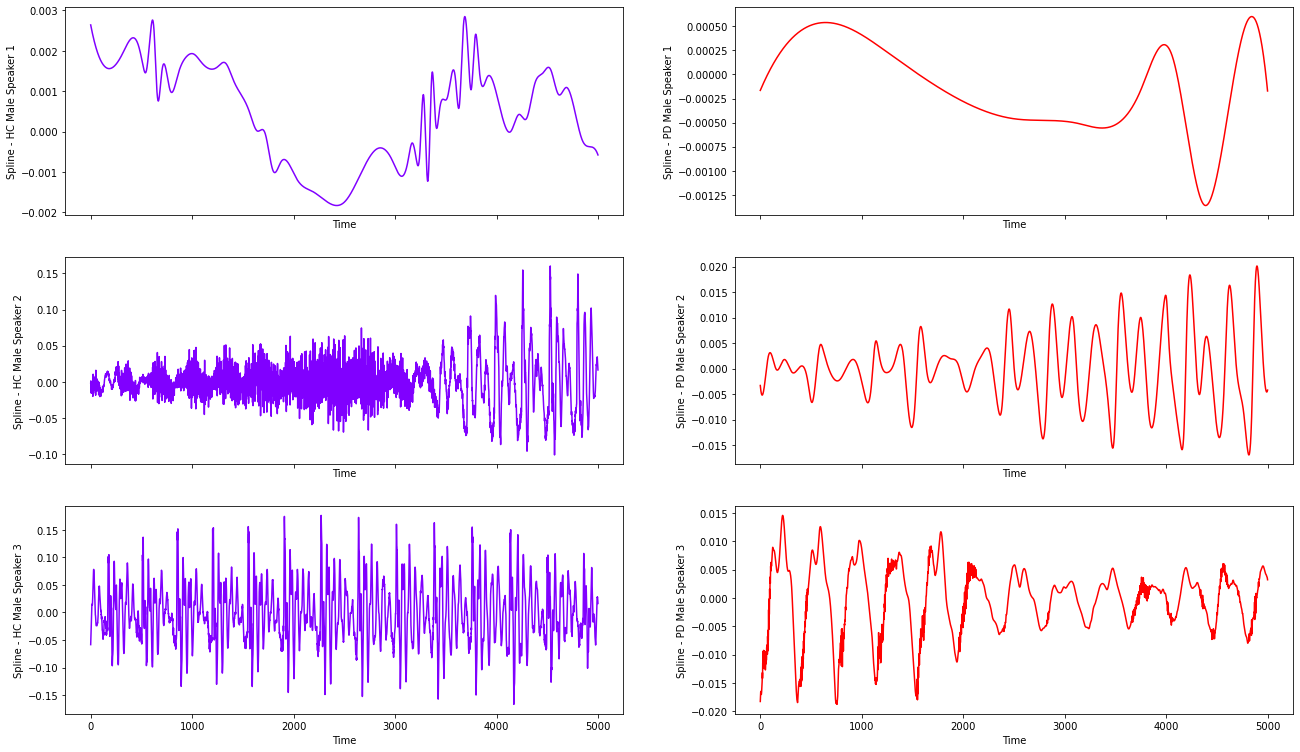

In [27]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(22,13))

for i in range(0,len(my_sig_hc_cent)):
    axes[i,0].plot(spl_eval_hc[i], color = rain_col[0])
    axes[i,1].plot(spl_eval_pd[i], color = rain_col[1])
    axes[i,0].set_ylabel(format("Spline - HC Male Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Time')
    axes[i,1].set_ylabel(format("Spline - PD Male Speaker " + str(i+1)))
    axes[i,1].set(xlabel = 'Time')  

In [28]:
spl_eval_hc = [np.vstack(spl_eval_hc[i]) for i in range(0,len(spl_eval_hc))]
spl_eval_pd = [np.vstack(spl_eval_pd[i]) for i in range(0,len(spl_eval_pd))]

In [29]:
C_hc_spl = [np.dot(spl_eval_hc[i], spl_eval_hc[i].T) for i in range(0, len(my_sig_hc))]
C_pd_spl = [np.dot(spl_eval_pd[i], spl_eval_pd[i].T)  for i in range(0, len(my_sig_pd))]


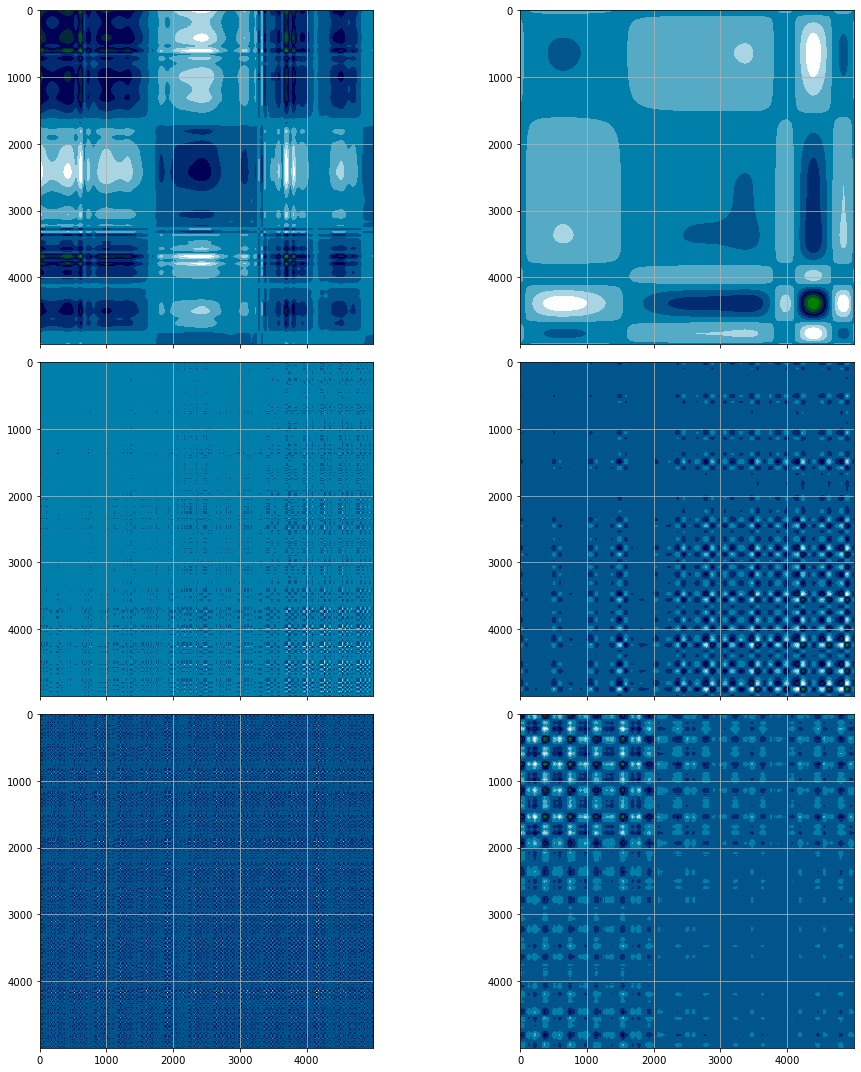

In [30]:
fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_hc_spl[i], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_pd_spl[i], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()



In [152]:
res_ckta_hc = [ [calculate_CKTA(C_hc[j],K[i]) for i in range(0,len(K))  ] for j in range(0,len(C_hc))]

In [153]:
res_ckta_pd = [ [calculate_CKTA(C_pd[j],K[i]) for i in range(0,len(K))  ] for j in range(0,len(C_pd))]

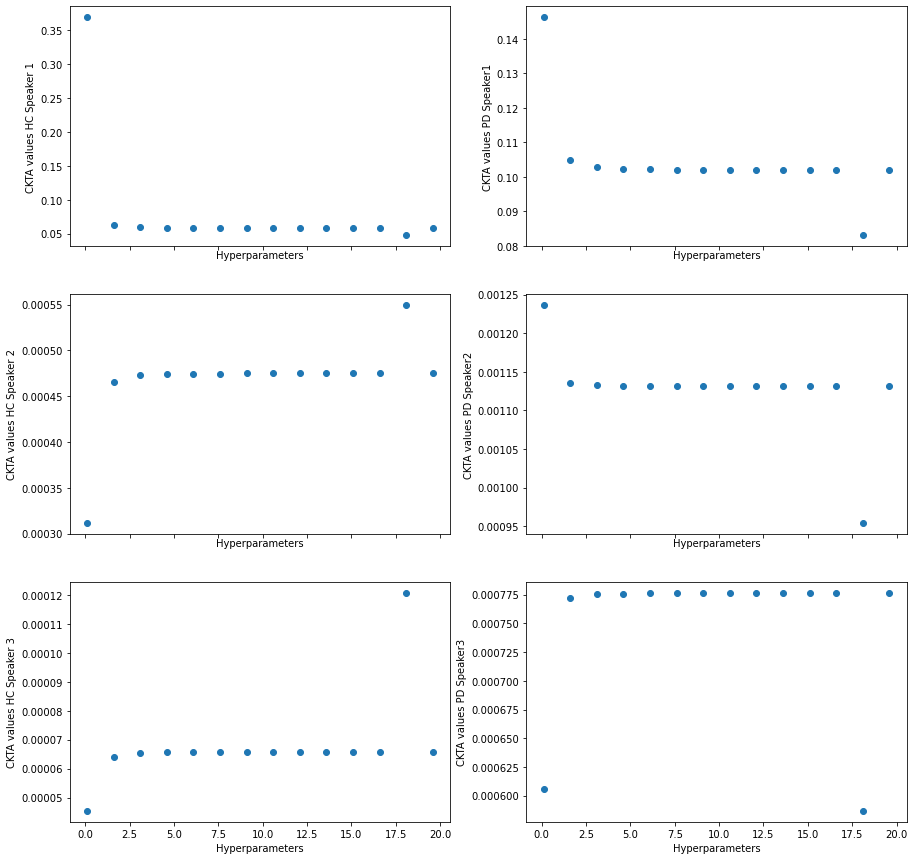

In [33]:
#PLOT FOR KERNEL 0 
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_hc[i])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_pd[i])
    axes[i,0].set_ylabel(format("CKTA values HC Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values PD Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  

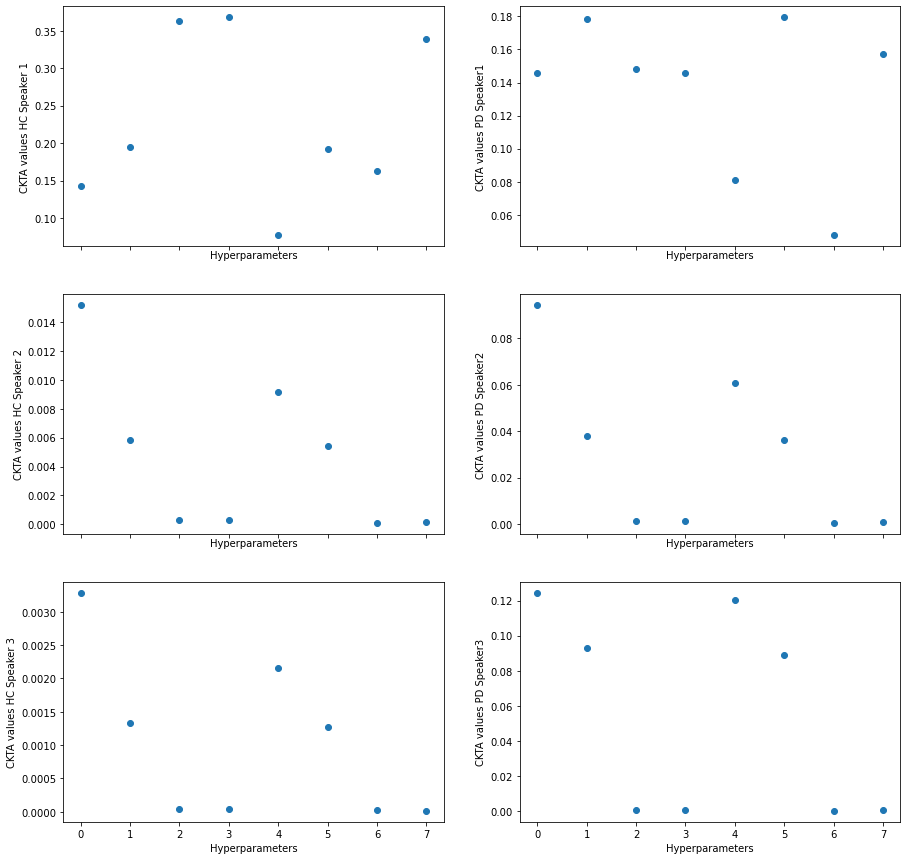

In [155]:
#PLOT FOR KERNEL 4 
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0,8), res_ckta_hc[i])
    axes[i,1].scatter(np.arange(0,8), res_ckta_pd[i])
    axes[i,0].set_ylabel(format("CKTA values HC Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values PD Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  

In [156]:
res_ckta_hc_sp = [ [calculate_CKTA(C_hc_spl[j],K[i]) for i in range(0,len(K))  ] for j in range(0,len(C_hc_spl))]

In [157]:
res_ckta_pd_sp = [ [calculate_CKTA(C_pd_spl[j],K[i]) for i in range(0,len(K))  ] for j in range(0,len(C_pd_spl))]

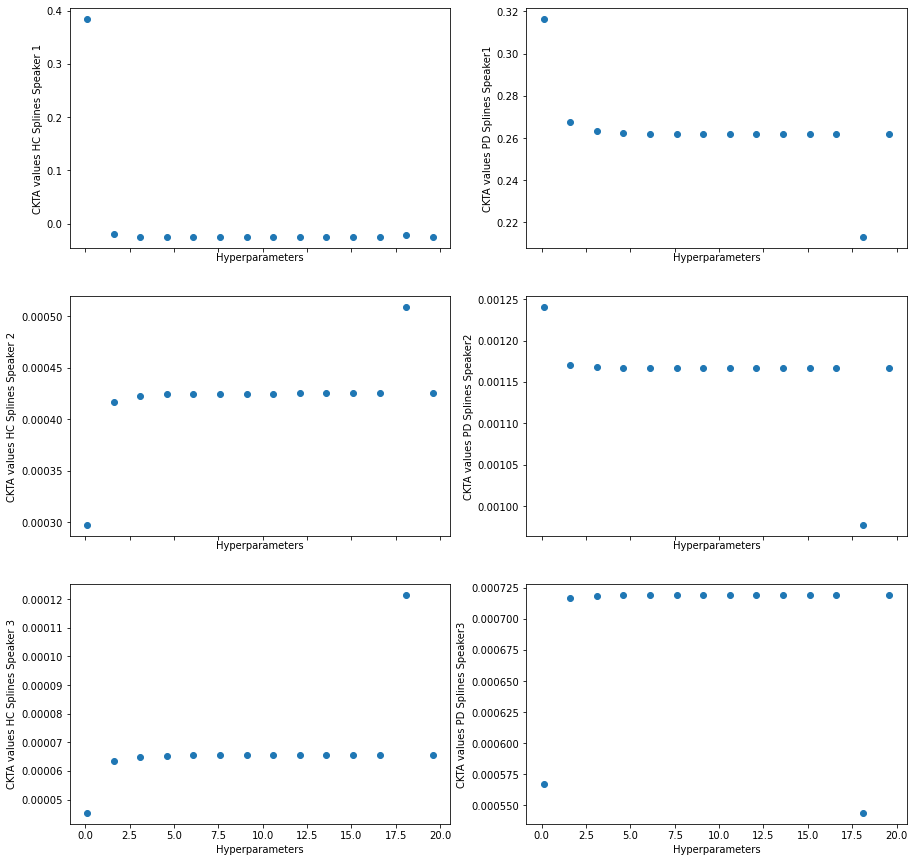

In [36]:
#PLOT FOR KERNEL 0 

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_hc_sp[i])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_pd_sp[i])
    axes[i,0].set_ylabel(format("CKTA values HC Splines Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values PD Splines Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  

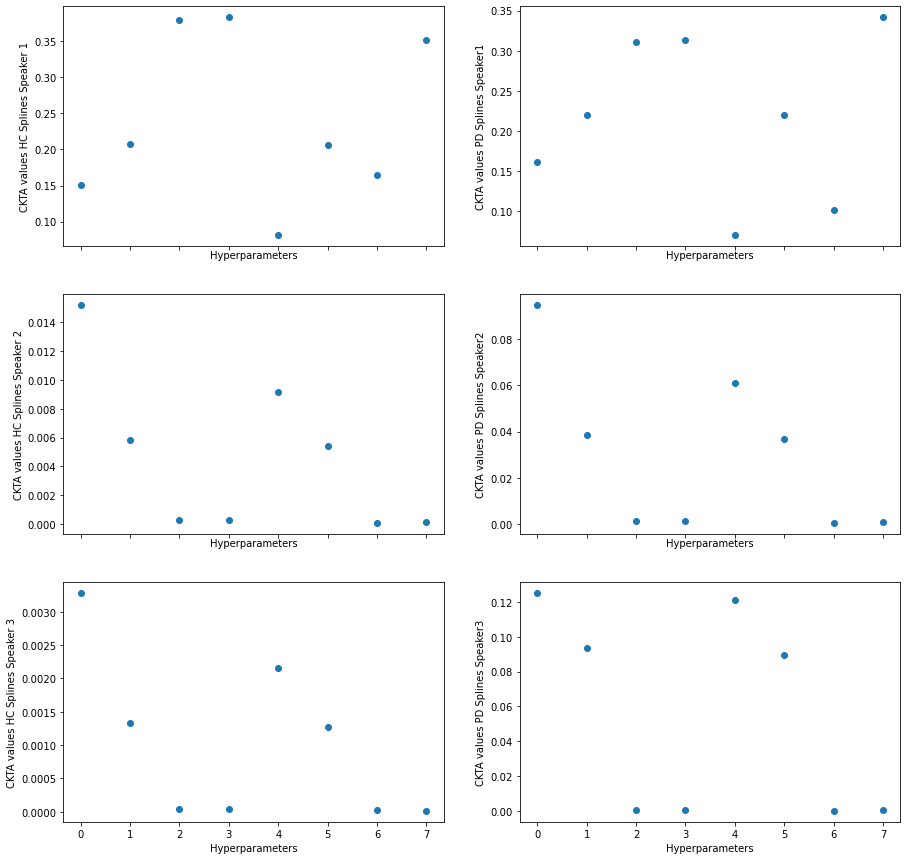

In [159]:
#PLOT FOR KERNEL 4 

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0,8), res_ckta_hc_sp[i])
    axes[i,1].scatter(np.arange(0,8), res_ckta_pd_sp[i])
    axes[i,0].set_ylabel(format("CKTA values HC Splines Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values PD Splines Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  

## IMFs

In [37]:
IMFs_train_5_hc_m = np.load ('C:\\Users\\Marta\\Desktop\\Parkinson_data\\Python_code\\Data_extraction_&_preliminaries\\Results\\IMFs_train_test\\IMFs_train_5_hc_m.npy ')
IMFs_train_5_pd_m = np.load ('C:\\Users\\Marta\\Desktop\\Parkinson_data\\Python_code\\Data_extraction_&_preliminaries\\Results\\IMFs_train_test\\IMFs_train_5_pd_m.npy ')

In [38]:
my_IMFs_hc = [IMFs_train_5_hc_m[0], IMFs_train_5_hc_m[1000],IMFs_train_5_hc_m[1700]]
my_IMFs_pd =  [IMFs_train_5_pd_m[0], IMFs_train_5_pd_m[2000],IMFs_train_5_pd_m[4000]]



In [71]:
my_IMFs_hc_cent = [(my_IMFs_hc[i] - np.mean(my_IMFs_hc[i], axis= 0)  )/ np.std(my_IMFs_hc[i], axis= 0)  
                   for i in range(0,len(my_IMFs_hc))]

my_IMFs_pd_cent = [ (my_IMFs_pd[i] - np.mean(my_IMFs_pd[i], axis= 0)  )/ np.std(my_IMFs_pd[i], axis= 0)  
                   for i in range(0,len(my_IMFs_pd))]


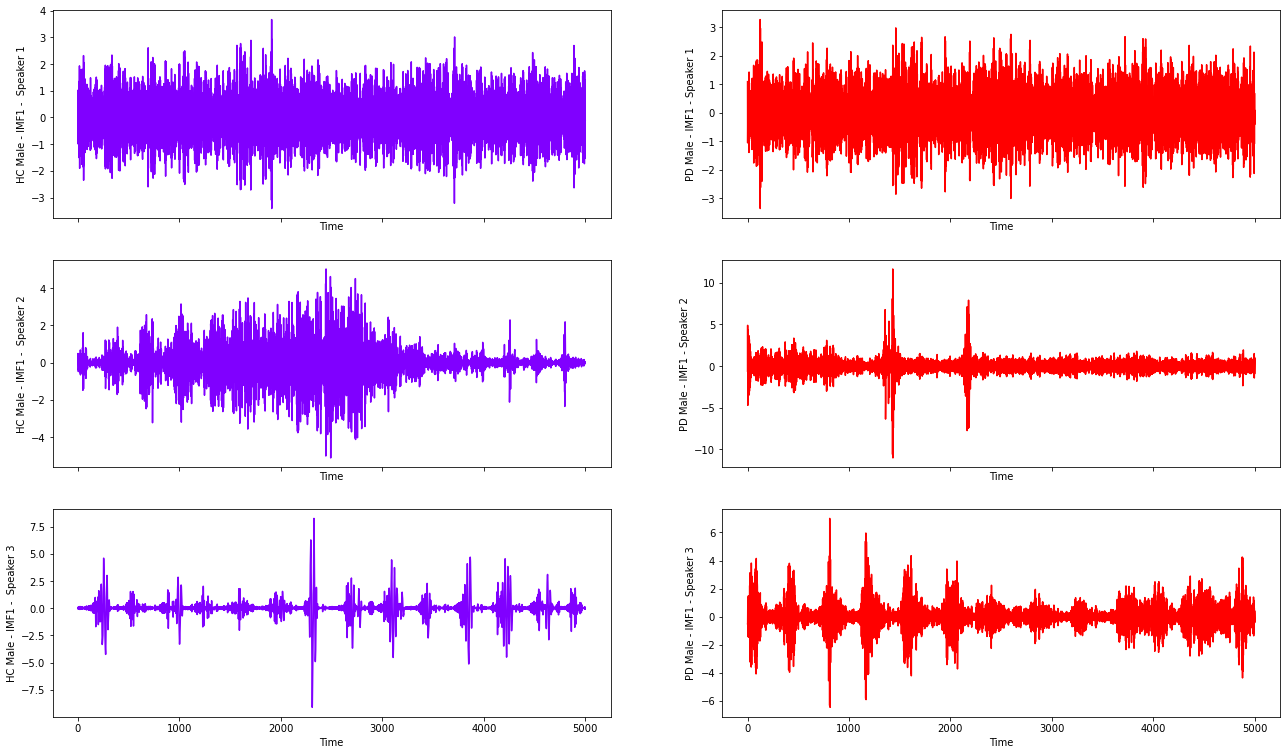

In [89]:
rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(22,13))

for i in range(0,len(my_sig_hc_cent)):
    axes[i,0].plot(my_IMFs_hc_cent[i][:,0], color = rain_col[0])
    axes[i,1].plot(my_IMFs_pd_cent[i][:,0], color = rain_col[1])
    axes[i,0].set_ylabel(format("HC Male - IMF1 -  Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Time')
    axes[i,1].set_ylabel(format("PD Male - IMF1 - Speaker " + str(i+1)))
    axes[i,1].set(xlabel = 'Time')  




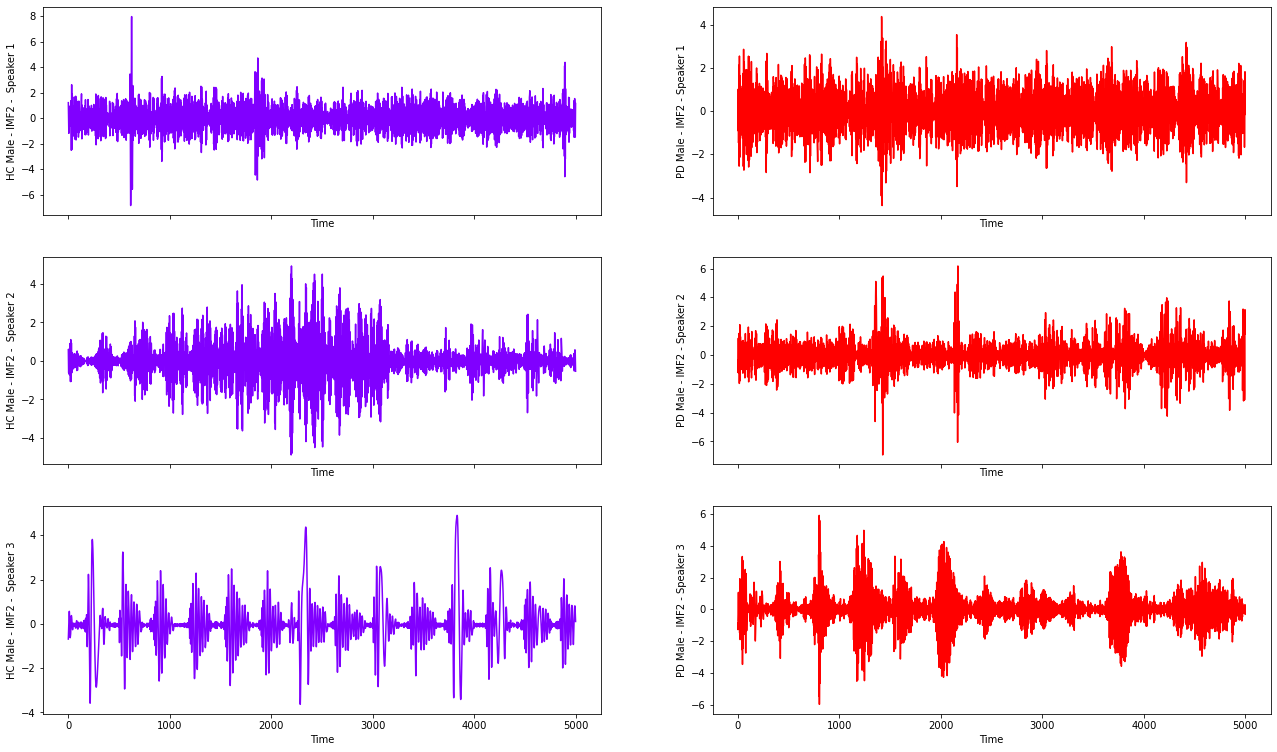

In [90]:
rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(22,13))

for i in range(0,len(my_sig_hc_cent)):
    axes[i,0].plot(my_IMFs_hc_cent[i][:,1], color = rain_col[0])
    axes[i,1].plot(my_IMFs_pd_cent[i][:,1], color = rain_col[1])
    axes[i,0].set_ylabel(format("HC Male - IMF2 -  Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Time')
    axes[i,1].set_ylabel(format("PD Male - IMF2 - Speaker " + str(i+1)))
    axes[i,1].set(xlabel = 'Time')  




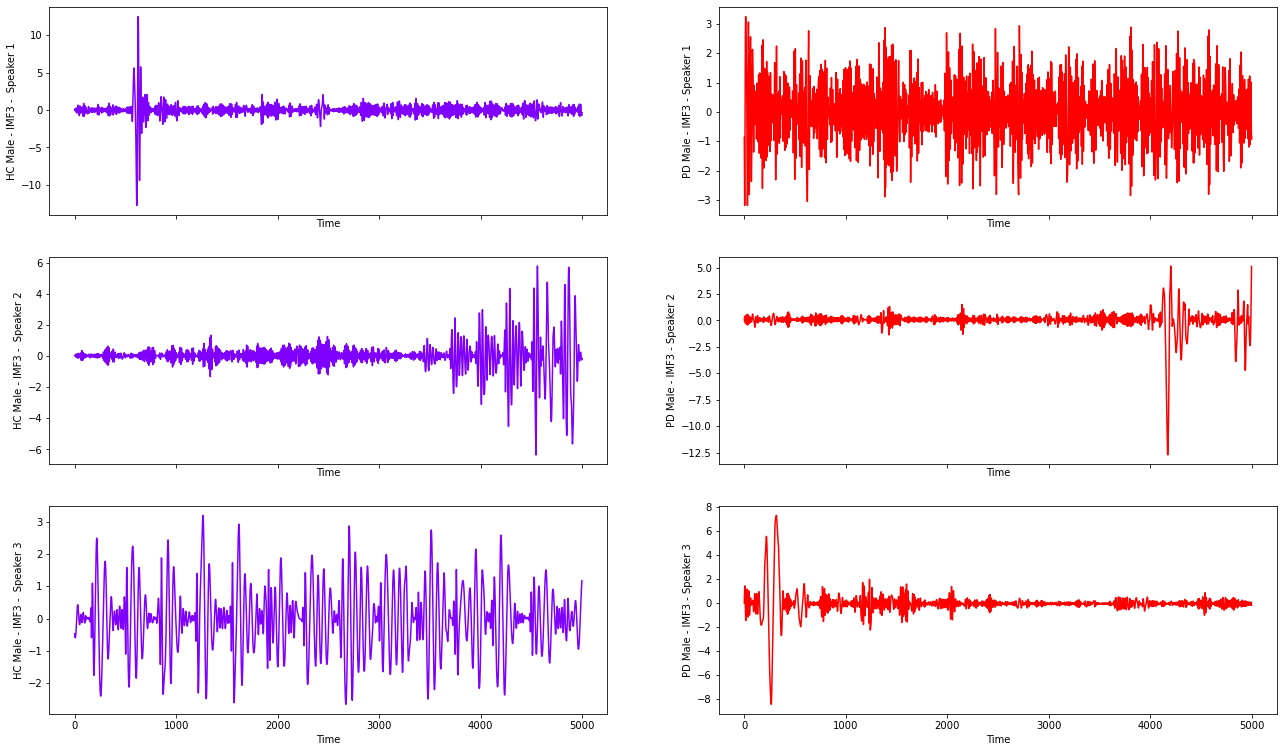

In [91]:
rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(22,13))

for i in range(0,len(my_sig_hc_cent)):
    axes[i,0].plot(my_IMFs_hc_cent[i][:,2], color = rain_col[0])
    axes[i,1].plot(my_IMFs_pd_cent[i][:,2], color = rain_col[1])
    axes[i,0].set_ylabel(format("HC Male - IMF3 -  Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Time')
    axes[i,1].set_ylabel(format("PD Male - IMF3 - Speaker " + str(i+1)))
    axes[i,1].set(xlabel = 'Time')  




[Text(0.5, 0, 'Time')]

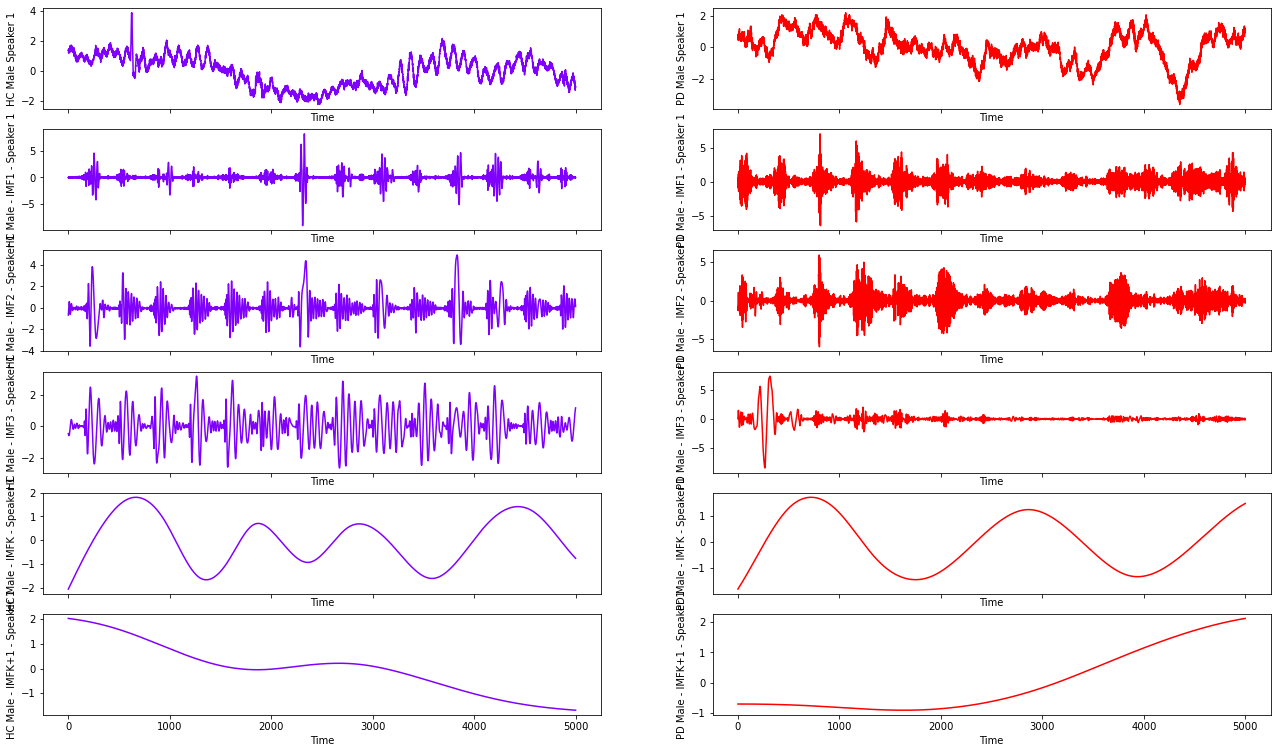

In [95]:
rain_col = CM.rainbow(np.linspace(0,1,2))

fig, axes = plt.subplots(nrows = 6, ncols = 2, sharex = True, figsize=(22,13))

axes[0,0].plot(my_sig_hc_cent[0], color = rain_col[0])
axes[0,1].plot(my_sig_pd_cent[0], color = rain_col[1])
axes[0,0].set_ylabel(format("HC Male Speaker 1" ))
axes[0,0].set(xlabel = 'Time')
axes[0,1].set_ylabel(format("PD Male Speaker 1"))
axes[0,1].set(xlabel = 'Time')  

axes[1,0].plot(my_IMFs_hc_cent[i][:,0], color = rain_col[0])
axes[1,1].plot(my_IMFs_pd_cent[i][:,0], color = rain_col[1])
axes[1,0].set_ylabel(format("HC Male - IMF1 - Speaker 1" ))
axes[1,0].set(xlabel = 'Time')
axes[1,1].set_ylabel(format("PD Male - IMF1 - Speaker 1"))
axes[1,1].set(xlabel = 'Time')  


axes[2,0].plot(my_IMFs_hc_cent[i][:,1], color = rain_col[0])
axes[2,1].plot(my_IMFs_pd_cent[i][:,1], color = rain_col[1])
axes[2,0].set_ylabel(format("HC Male - IMF2 - Speaker 1" ))
axes[2,0].set(xlabel = 'Time')
axes[2,1].set_ylabel(format("PD Male - IMF2 - Speaker 1"))
axes[2,1].set(xlabel = 'Time')


axes[3,0].plot(my_IMFs_hc_cent[i][:,2], color = rain_col[0])
axes[3,1].plot(my_IMFs_pd_cent[i][:,2], color = rain_col[1])
axes[3,0].set_ylabel(format("HC Male - IMF3 - Speaker 1" ))
axes[3,0].set(xlabel = 'Time')
axes[3,1].set_ylabel(format("PD Male - IMF3 - Speaker 1"))
axes[3,1].set(xlabel = 'Time')


axes[4,0].plot(my_IMFs_hc_cent[i][:,3], color = rain_col[0])
axes[4,1].plot(my_IMFs_pd_cent[i][:,3], color = rain_col[1])
axes[4,0].set_ylabel(format("HC Male - IMFK - Speaker 1" ))
axes[4,0].set(xlabel = 'Time')
axes[4,1].set_ylabel(format("PD Male - IMFK - Speaker 1"))
axes[4,1].set(xlabel = 'Time')


axes[5,0].plot(my_IMFs_hc_cent[i][:,4], color = rain_col[0])
axes[5,1].plot(my_IMFs_pd_cent[i][:,4], color = rain_col[1])
axes[5,0].set_ylabel(format("HC Male - IMFK+1 - Speaker 1" ))
axes[5,0].set(xlabel = 'Time')
axes[5,1].set_ylabel(format("PD Male - IMFK+1 - Speaker 1"))
axes[5,1].set(xlabel = 'Time')







In [120]:
C_IMFs_hc = [[np.dot(np.vstack(my_IMFs_hc_cent[j][:,i]), np.vstack(my_IMFs_hc_cent[j][:,i]).T) for i in range(0,5)] 
                                                                         for j in range(0,len(my_IMFs_hc_cent))]

C_IMFs_pd = [[np.dot(np.vstack(my_IMFs_pd_cent[j][:,i]), np.vstack(my_IMFs_pd_cent[j][:,i]).T) for i in range(0,5)] 
                                                                         for j in range(0,len(my_IMFs_pd_cent))]

In [112]:
len(C_IMFs_pd)

3

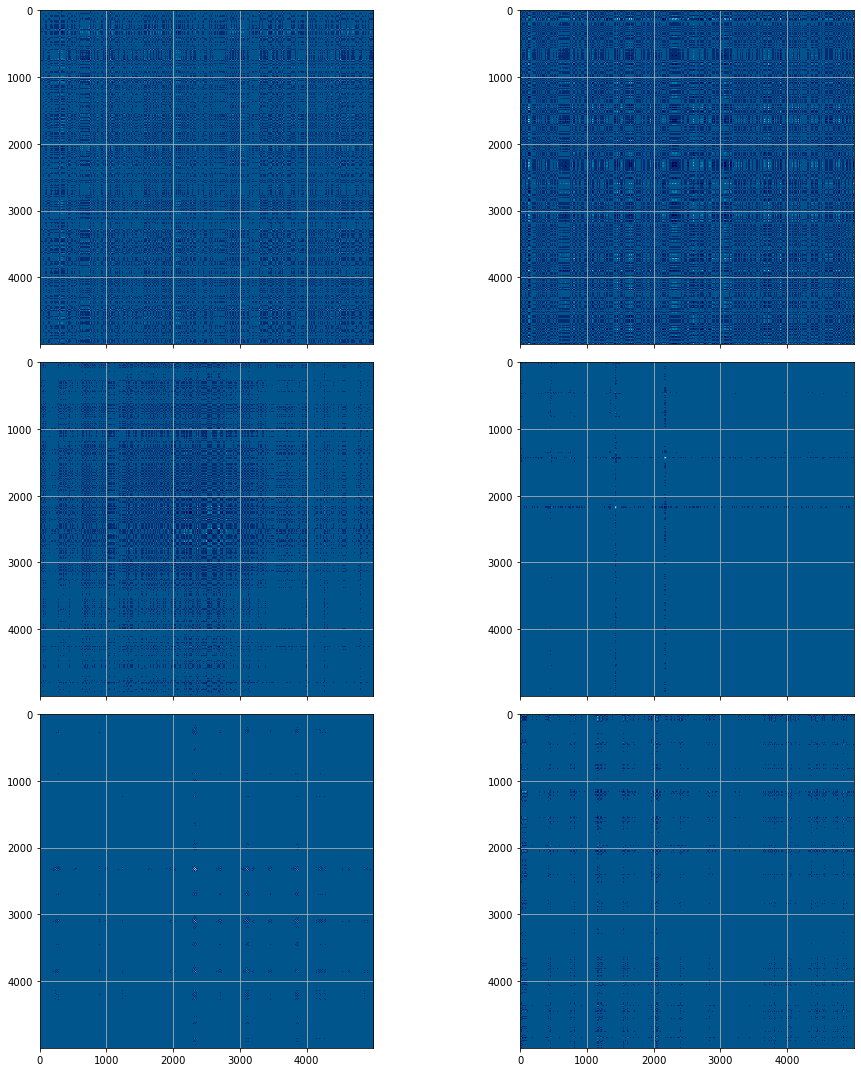

In [113]:
#GRAM MATRICES IMF1

fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_IMFs_hc[i][0], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_IMFs_pd[i][0], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()


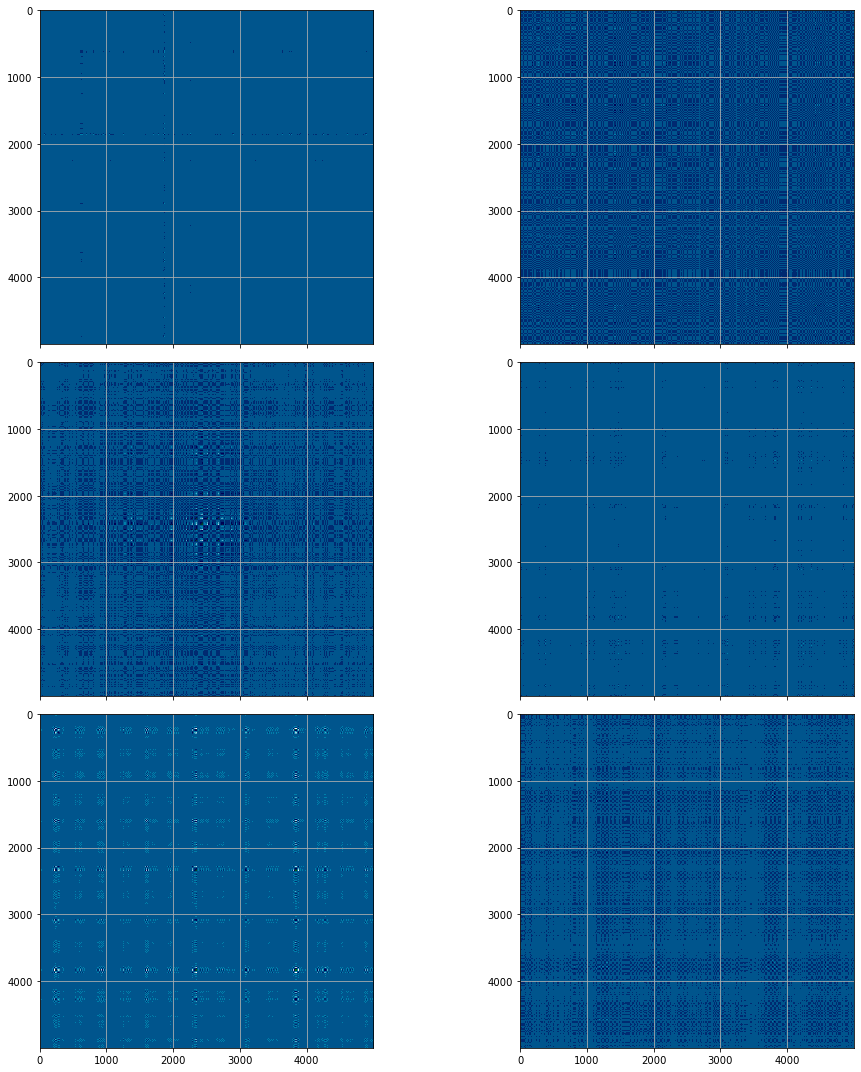

In [114]:
#GRAM MATRICES IMF2

fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_IMFs_hc[i][1], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_IMFs_pd[i][1], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()


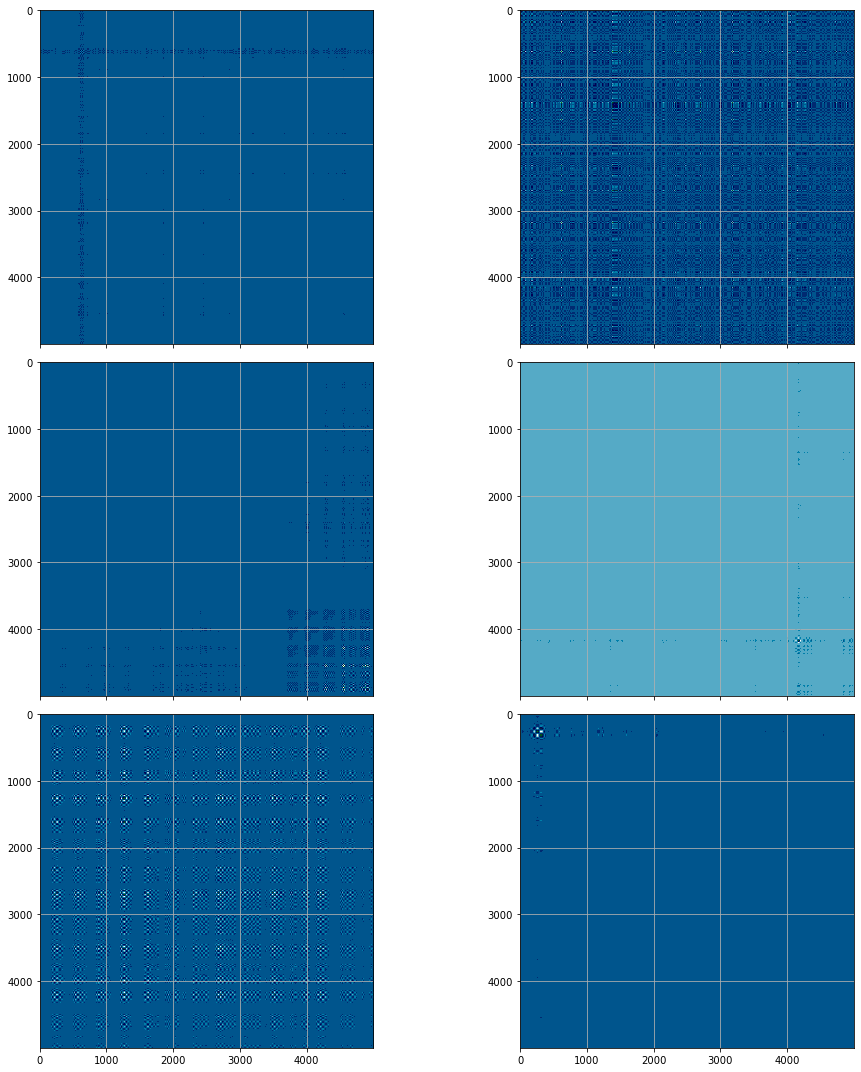

In [115]:
#GRAM MATRICES IMF3

fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_IMFs_hc[i][2], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_IMFs_pd[i][2], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()

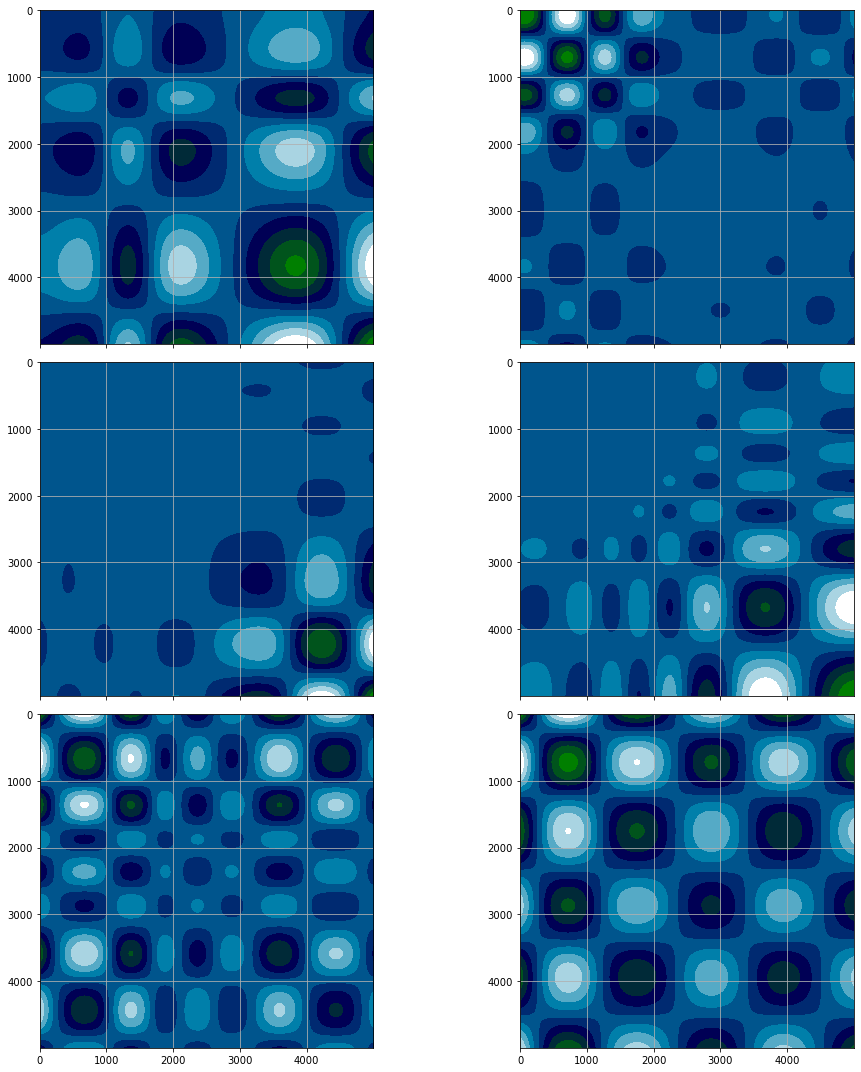

In [116]:
#GRAM MATRICES IMFK

fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_IMFs_hc[i][3], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_IMFs_pd[i][3], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()

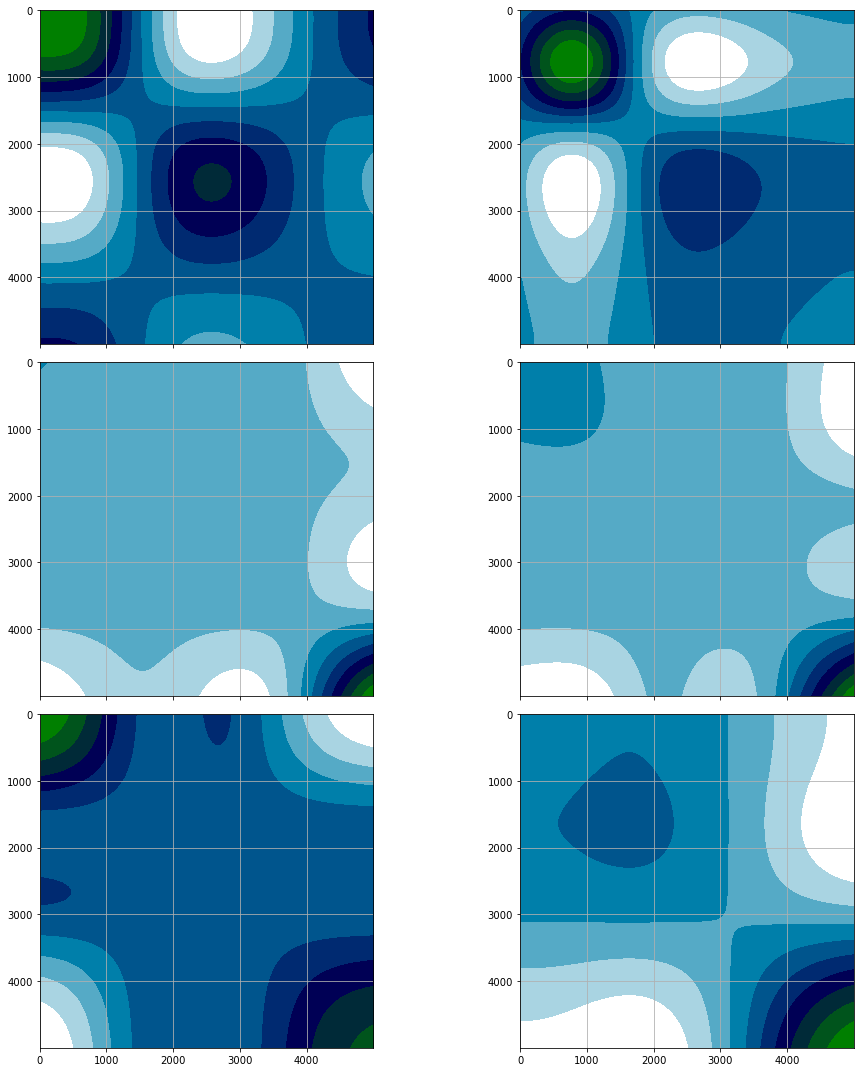

In [121]:
#GRAM MATRICES IMFK+1

fig, axis = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

cmap = CM.get_cmap('ocean_r', 10)

for i in range(0,len(my_sig_hc)):
    axis[i,0].imshow(C_IMFs_hc[i][4], interpolation="nearest", cmap=cmap)
    axis[i,0].grid(True)
    axis[i,1].imshow(C_IMFs_pd[i][4], interpolation="nearest", cmap=cmap)
    axis[i,1].grid(True)
fig.tight_layout()

In [160]:
res_ckta_IMFs_hc = [[[calculate_CKTA(C_IMFs_hc[j][h],K[i]) for i in range(0,len(K))  ] 
                     for h in range(0,5)] 
                    for j in range(0,len(C_IMFs_hc))]

In [161]:
res_ckta_IMFs_pd = [[[calculate_CKTA(C_IMFs_pd[j][h],K[i]) for i in range(0,len(K))  ] 
                     for h in range(0,5)] 
                    for j in range(0,len(C_IMFs_pd))]

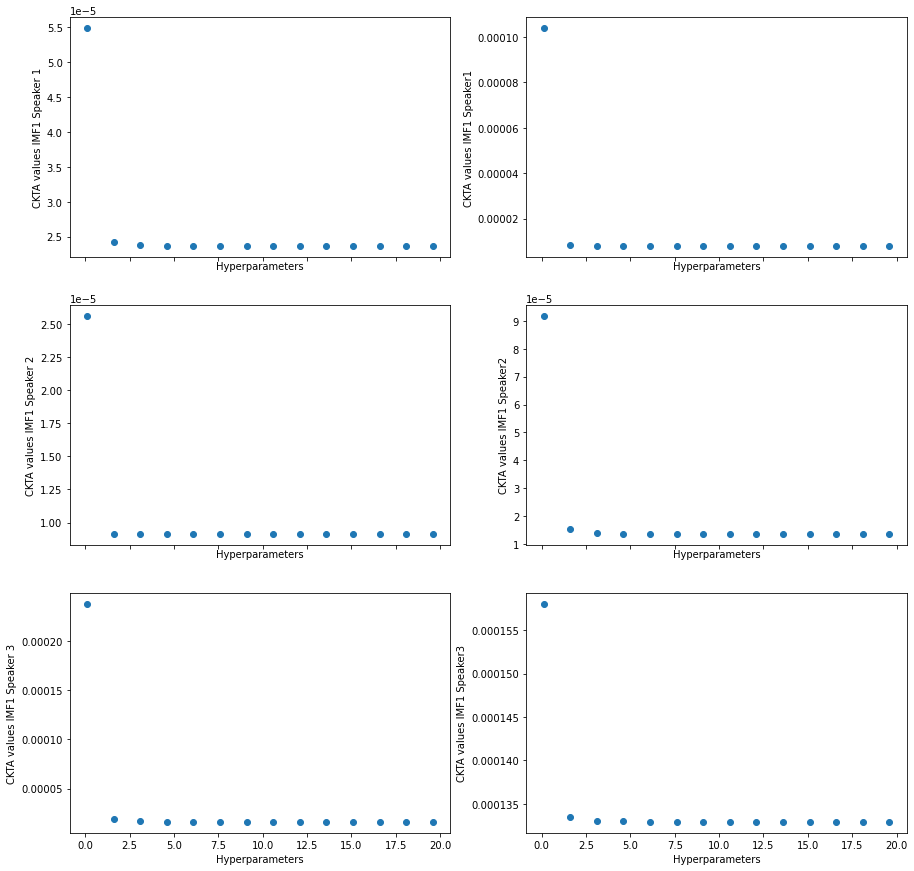

In [141]:
#CKTA IMF1 - Kernel 0

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_hc[i][0])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_pd[i][0])
    axes[i,0].set_ylabel(format("CKTA values IMF1 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF1 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


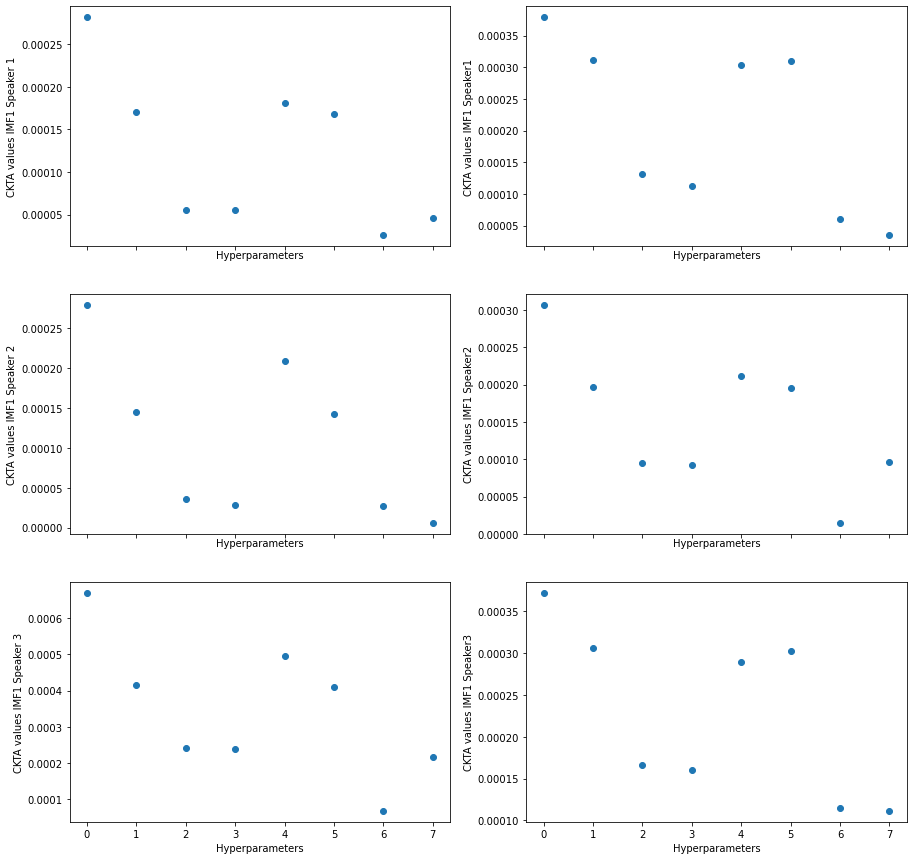

In [162]:
#CKTA IMF1 - Kernel 4

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0, 8), res_ckta_IMFs_hc[i][0])
    axes[i,1].scatter(np.arange(0, 8), res_ckta_IMFs_pd[i][0])
    axes[i,0].set_ylabel(format("CKTA values IMF1 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF1 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


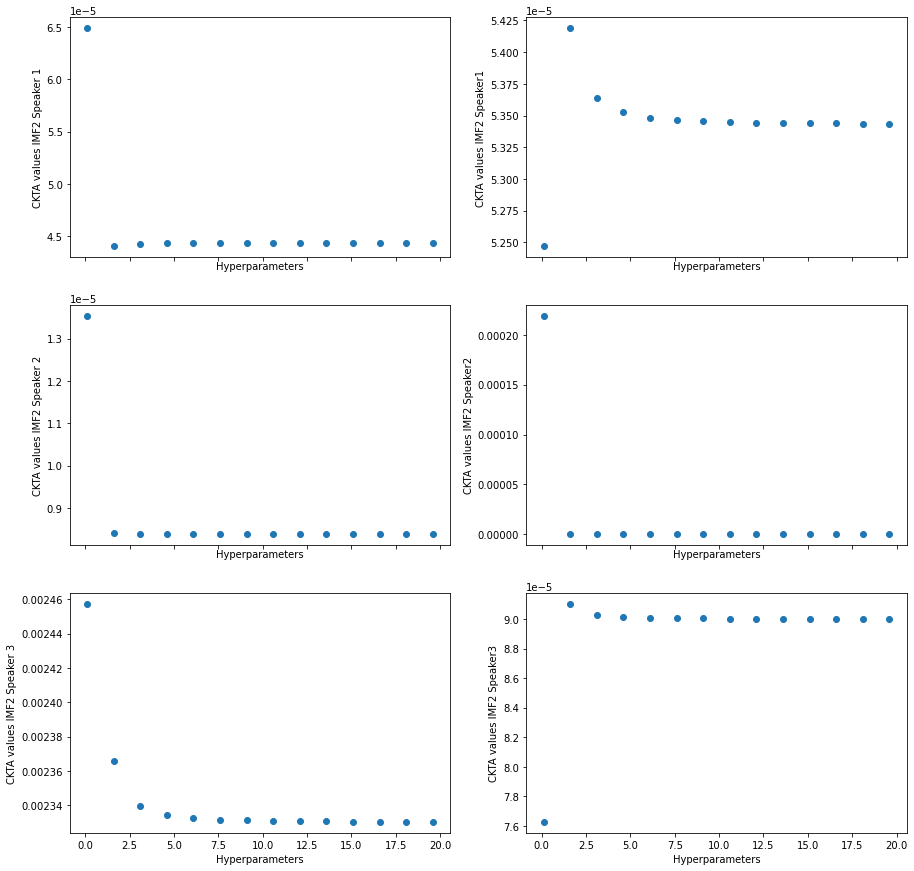

In [142]:
#CKTA IMF2 - Kernel 0 

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_hc[i][1])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_pd[i][1])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


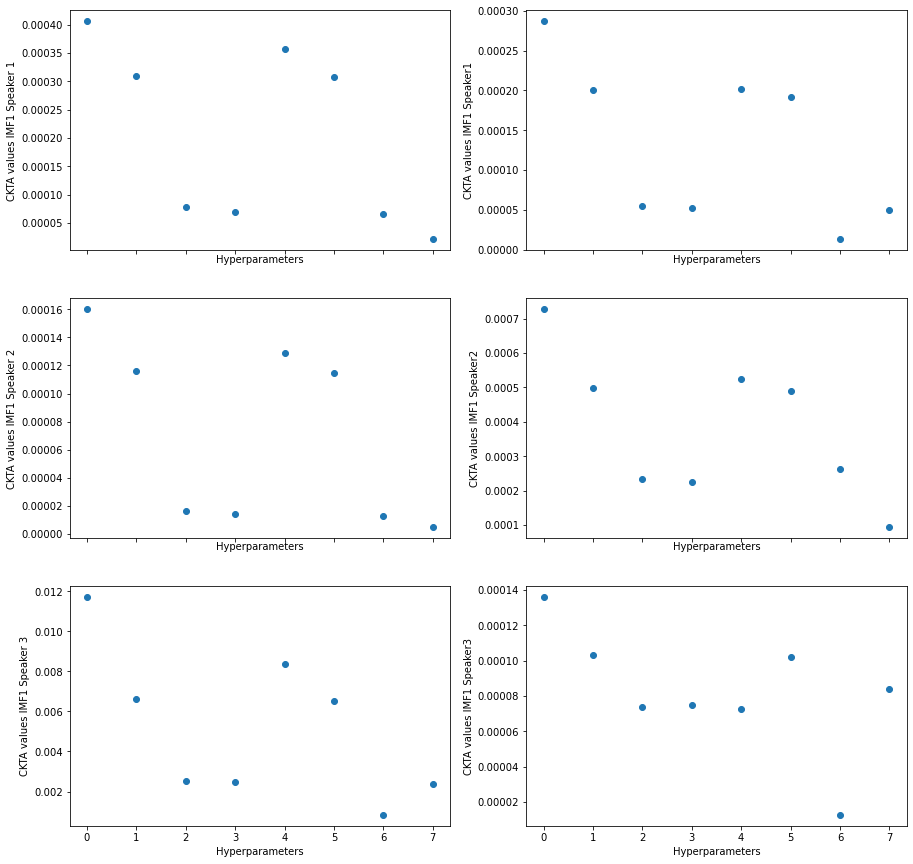

In [163]:
#CKTA IMF2 - Kernel 4

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0, 8), res_ckta_IMFs_hc[i][1])
    axes[i,1].scatter(np.arange(0, 8), res_ckta_IMFs_pd[i][1])
    axes[i,0].set_ylabel(format("CKTA values IMF1 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF1 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


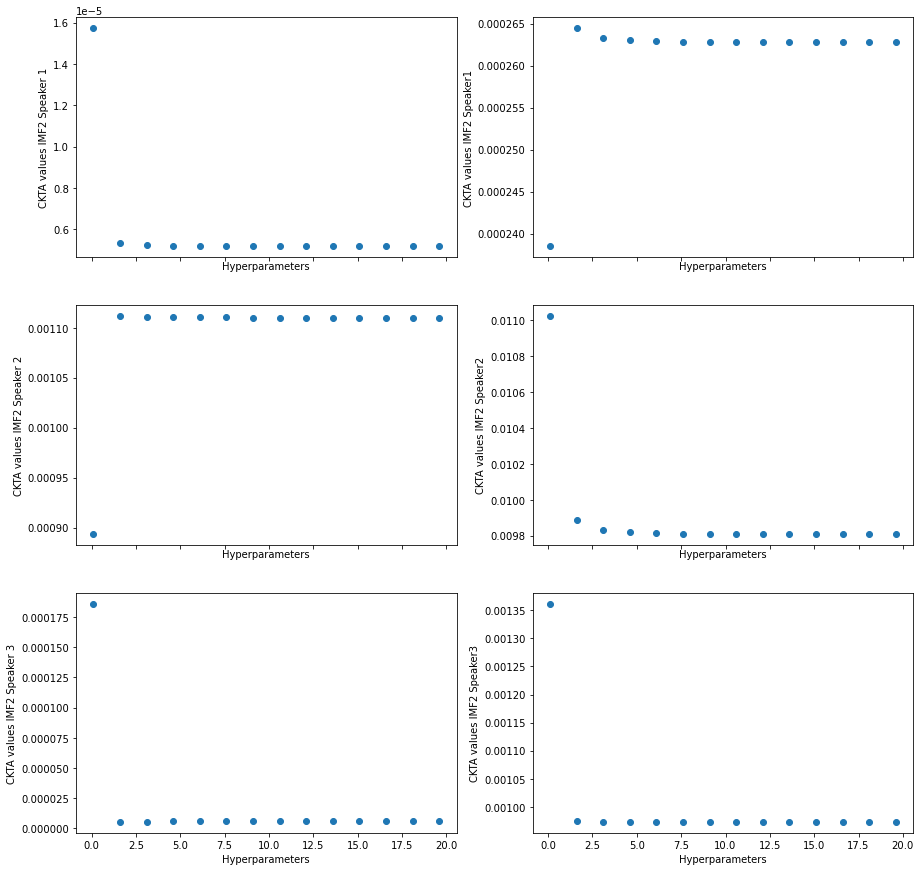

In [143]:
#CKTA IMF3 - Kernel 0

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_hc[i][2])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_pd[i][2])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


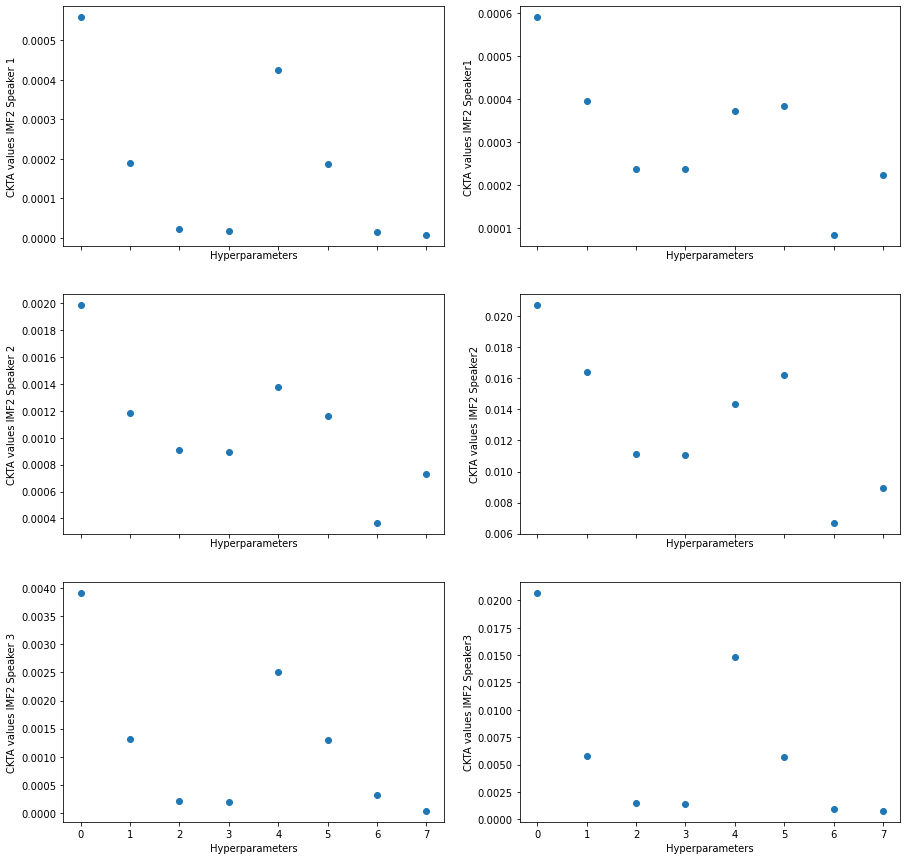

In [164]:
#CKTA IMF3 - Kernel 4

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0,8), res_ckta_IMFs_hc[i][2])
    axes[i,1].scatter(np.arange(0,8), res_ckta_IMFs_pd[i][2])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


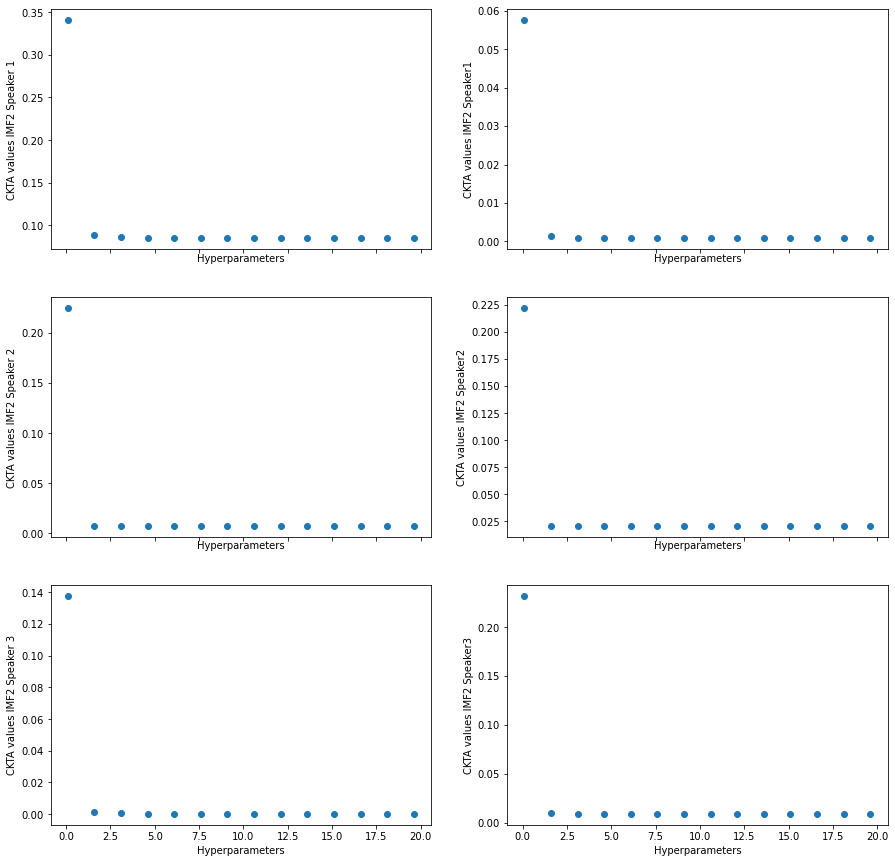

In [144]:
#CKTA IMFK - Kernel 0

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_hc[i][3])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_pd[i][3])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


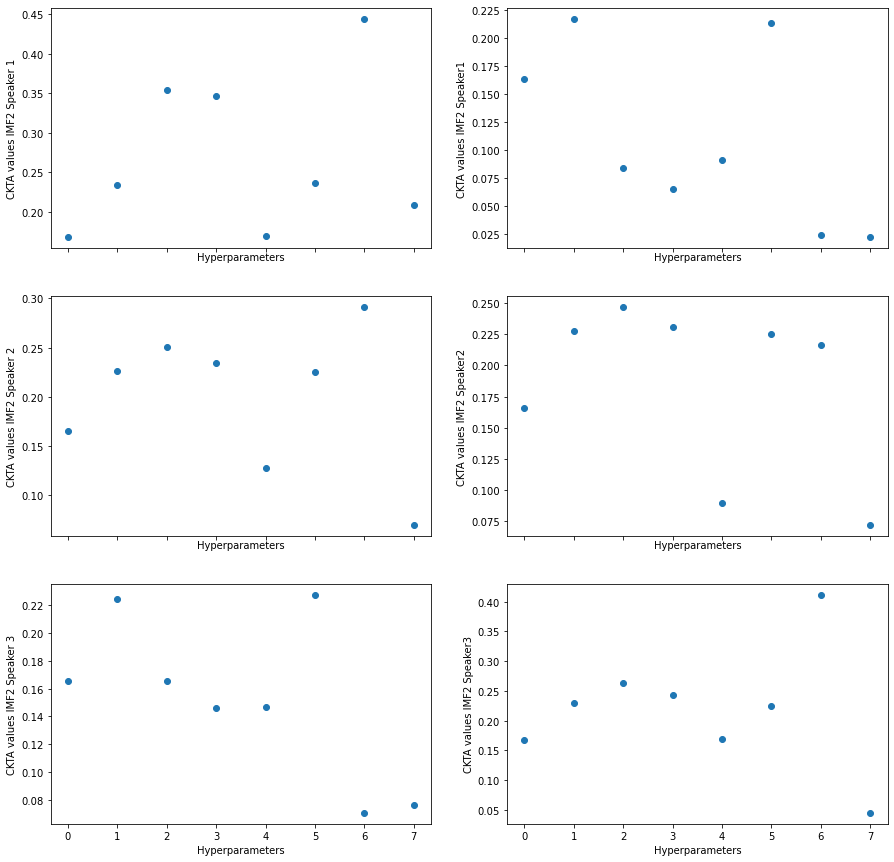

In [165]:
#CKTA IMFK - Kernel 4

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0,8), res_ckta_IMFs_hc[i][3])
    axes[i,1].scatter(np.arange(0,8), res_ckta_IMFs_pd[i][3])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


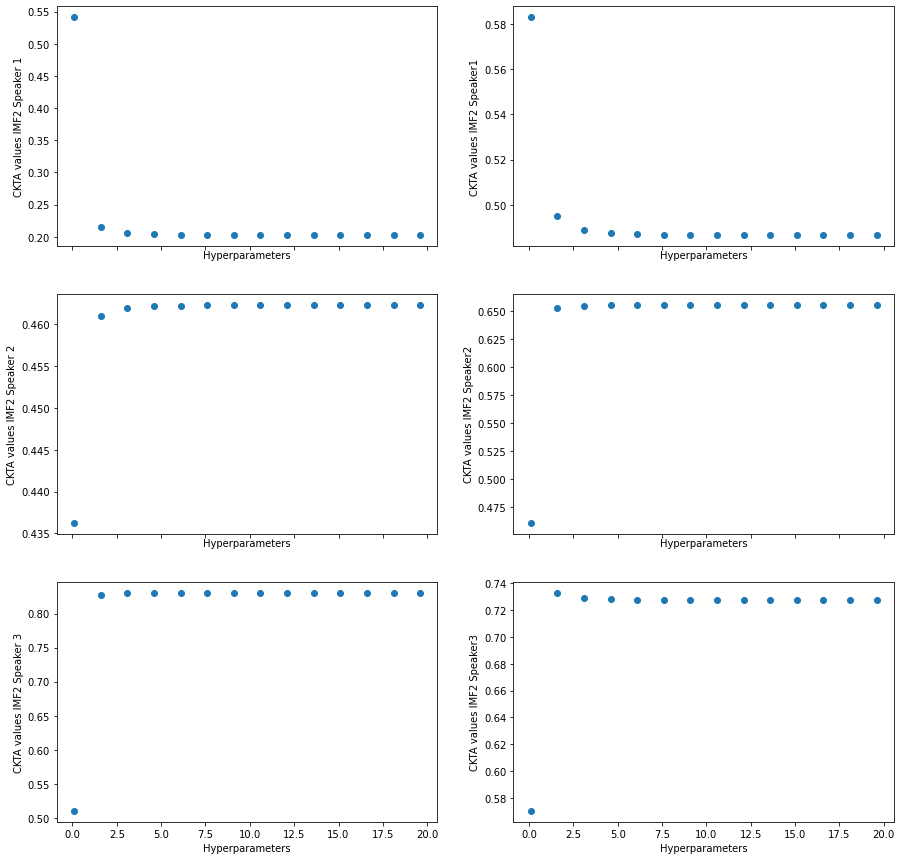

In [145]:
#CKTA IMFK - Kernel 0

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_hc[i][4])
    axes[i,1].scatter(np.arange(0.1, 20, 1.5), res_ckta_IMFs_pd[i][4])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


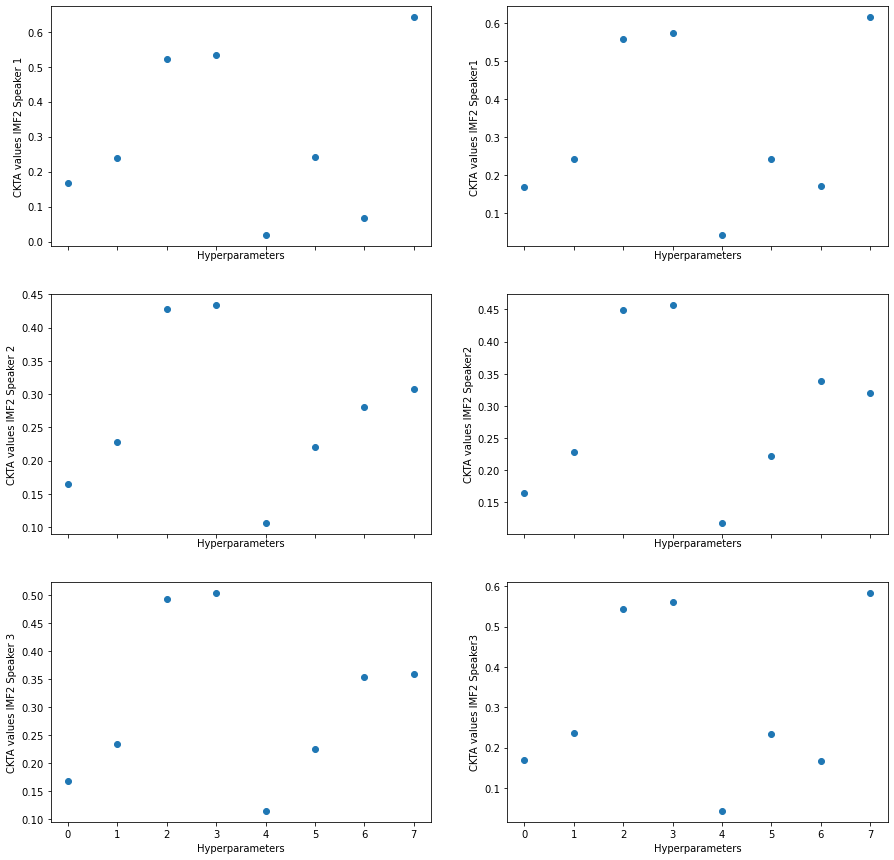

In [167]:
#CKTA IMFK - Kernel 4

fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize=(15,15))

for i in range(0,len(res_ckta_hc)):
    axes[i,0].scatter(np.arange(0,8), res_ckta_IMFs_hc[i][4])
    axes[i,1].scatter(np.arange(0,8), res_ckta_IMFs_pd[i][4])
    axes[i,0].set_ylabel(format("CKTA values IMF2 Speaker " + str(i+1)))
    axes[i,0].set(xlabel = 'Hyperparameters')
    axes[i,1].set_ylabel(format("CKTA values IMF2 Speaker" + str(i+1)))
    axes[i,1].set(xlabel = 'Hyperparameters')  


In [166]:
np.save('res_ckta_IMFs_hc_K0',res_ckta_IMFs_hc)
np.save('res_ckta_IMFs_pd_K0',res_ckta_IMFs_pd)
